In [1]:
#%% Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
## Deterministic solution
def sdd(x, D, m, j):
    return j / np.sqrt(D * m) * np.exp(-x / np.sqrt(D / m))

In [3]:
#%% Define Parameters
    
## Simulation parameters
Lx      = 500                   # length of system (500 um)
dx      = 1.00                  # camera pixel size (1 um)
nx      = round(Lx/dx)          # number of positions (pixels)
xx      = np.arange(nx+1)*dx    # x bin edges

Ly      = 500                   # length of system (500 um)
dy      = 1.00                  # camera pixel size (1 um)
ny      = round(Ly/dy)          # number of positions (pixels)
yy      = np.arange(ny+1)*dy    # y bin edges

## Dynamic parameters
D               = 10          # diffusion constant
Decay_Time      = 35         # decay time in minutes
mu              = (Decay_Time*60) ** (-1)  # disassociation rate
J               = 0.003            # Insertion rate (0.0015 tops at 660)

## Probabilities and derived parameters
dt      = dx**2/(D*2*2)         # assumes dy = dx
p_J     = J * dt  #number of source position
p_mu    = mu * dt
k_on = 0.6
k_off = 0.5


In [4]:
## Time Variables

Ttotal  = 1*60*60               # time in seconds
nt      = round(Ttotal/dt)+1
dtsave  = 6*60              # save every "10 mins"
dsave   = round(dtsave/dt)      
nsave   = round(Ttotal/dtsave)+1

In [5]:
#%% Run simulation for SDD model
distrib = np.empty((0,2)) #A matrix with 2 cols and 0 rows
density = np.zeros((nx,nsave)) #A 2-tuple that has info on pixels on y (horizontal)//
# x (vertical) and number of saves
#create another adt 



(0, 2)

In [6]:
## Particle Movement (Diffusion)
start = time.time() #number of particles
moveTable = np.array([[-1,0], [1,0], [0,1], [0,-1]]) #Left,Right,Up,Down
count = 0
c = 0
for count in range (1,nt): #change to 1,nt later
    move = np.zeros((0,2))
    add = np.random.poisson(p_J*Ly) #number of new particles
    new = np.zeros((add,2)) #A matrix with 2 cols and number of new particles as rows
    for ii in new:
        ii[1] = ii[1] + int(np.random.uniform(0,Ly))
    distrib = np.append(distrib, new, axis=0)
    movePart = np.random.choice([0,1,2,3], size=len(distrib))
    numPart = len(distrib)
    move = np.concatenate((move,moveTable[movePart]),)
    distrib = distrib + move #temp fix for boundaries
    distrib = np.abs(distrib)
    distrib[:,0] = np.where(distrib[:,0] > Lx,Lx - np.abs(distrib[:,0] - Lx), distrib[:,0])
    distrib[:,1] = np.where(distrib[:,1] > Ly,np.abs(distrib[:,0] - Ly), distrib[:,1])
    if numPart > 0:
        meanDecay = p_mu* numPart
        dead = np.random.poisson(meanDecay)
        kill = np.random.choice(numPart, dead, replace=False)
        distrib = np.delete(distrib,kill,0)
    if count%dsave == 0:
        ind = round(count/dsave) #change later
        distribX = np.array([])
        for i in distrib:
            press = np.array([i[0]])
            distribX = np.concatenate ((distribX, press),)
        out, bins = np.histogram(distribX, xx)
        density[:,ind] = out /Ly
        a = len(distrib)
        print(f'At time step {count} out of {nt-1} with {len(distrib)}  particles')
        if count >= 0.9*nt:
            if (count % 1000) == 0:
                distribN = np.array([])
                for i in distrib:
                    press = np.array([i[0]])
                    distribN = np.concatenate ((distribN, press),)
                if c == 0:
                
                    out, bins = np.histogram(distribN, xx)
                    out = out/Ly
                    denseNew = np.reshape(out, (500, 1))
                    denseOut = denseNew
                    c += 1
                else:
                    out, bins = np.histogram(distribN, xx)
                    out = out/ Ly
                    denseNew = np.reshape(out, (500, 1))
                    denseOut = np.append(denseOut, denseNew, axis = 1)
        #np.savetxt(str(ind)+'distrib.csv', distrib, fmt='%i', delimiter=",") #seems to work, next try to label x and y
        img = np.zeros((Ly+1,Lx+1))
        for coord in distrib:
            img[int(coord[1]) , int(coord[0])] = 1
        im = Image.fromarray(img)
        #im.save(str(ind)+'.tif')
#anecdote: blunders made include not vectorizing (97% faster) and nested if else's (94% faster without)
elapsed = time.time() - start


At time step 14400 out of 144000 with 482  particles
At time step 28800 out of 144000 with 906  particles
At time step 43200 out of 144000 with 1227  particles
At time step 57600 out of 144000 with 1528  particles
At time step 72000 out of 144000 with 1776  particles
At time step 86400 out of 144000 with 1979  particles
At time step 100800 out of 144000 with 2131  particles
At time step 115200 out of 144000 with 2301  particles
At time step 129600 out of 144000 with 2447  particles
At time step 144000 out of 144000 with 2520  particles


0.0004761904761904762

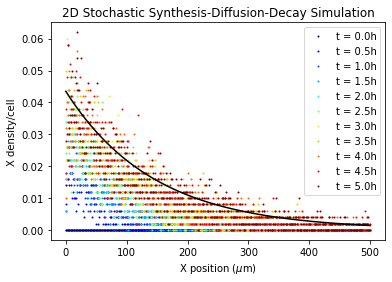

In [8]:
anly = sdd(xx, D, mu, J)
color=iter(plt.cm.jet(np.linspace(0,1,nsave)))   
for jj in range(nsave):
    c=next(color)
    plt.plot(np.arange(nx), density[:, jj], 
        'o', color=c, markersize=1, 
         label='t = ' + str(round(jj*1/2,1)) + 'h')   
plt.plot(xx,anly, color=[0 ,0 ,0])
plt.legend()
plt.title('2D Stochastic Synthesis-Diffusion-Decay Simulation')
plt.ylabel('X density/cell')
plt.xlabel('X position ($\mu$m)')
xi = np.arange(0,501,step = 100)
plt.xticks(xi,xi);
plt.savefig('2dsdd.png')

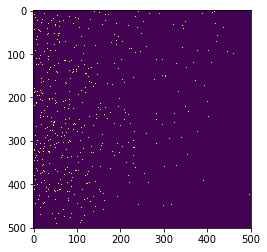

In [9]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()
#plt.imsave('test.png', img)

In [10]:
#File_data = np.loadtxt("test.txt", dtype=int)
#print(File_data) load in txt tile

In [11]:
#im = Image.fromarray(img)
#im.save('run1.tif')
#from PIL import Image
#im1 = np.asarray(Image.open("run1.tif"))
#(im1 == img).all() #verify same

#### Test Codes
-----------------------------

Object ` plt.hist()` not found.


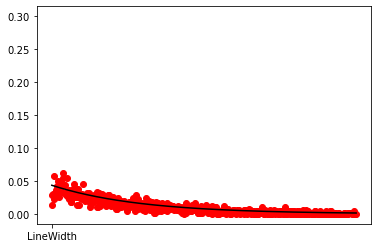

In [13]:
plt.plot(np.arange(nx), np.mean(denseOut, axis=1), 'ro')
plt.plot(xx, sdd(xx, D, mu, J), 'k-', 'LineWidth', 0.3)

In [14]:
from scipy.optimize import curve_fit
def expFn(x, a, b):
    return a * np.exp(b * -x)

# We see only the latter half of the data
ydata = np.mean(denseOut, axis=1)[26:]
xdata = np.arange(0,474)

popt, pcov = curve_fit(expFn, xdata, ydata)
D_pred = mu/popt[1]**2
D_pred

<ipython-input-14-f06a3b5dd9ba>:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * -x)


8.732687179651535

array([[187.,  56.],
       [101.,  98.],
       [137., 258.],
       ...,
       [  5., 215.],
       [  5., 338.],
       [  3., 380.]])

array([[187.,  56.],
       [101.,  98.],
       [137., 258.],
       ...,
       [  5., 215.],
       [  5., 338.],
       [  3., 380.]])